## Similarity scores to find YouTube video skips
This notebook calculates the similarity score of subsequent 1 second frames from a YouTube video. Hopefully, this will help us identify the arbitrary jumps that exist in the video.

In [38]:
import os
os.chdir('../pipeline')
import youtube_utils as yt
import database
import extract_SOI_info as soi
import re
import numpy as np

db = database.Database()
dives_yt_df = db.sql_query_youtube(pd_out=True)
dives_yt_df.head()

,youtube_id,dive_id
0,HbyWEN1vRRw,S0055
1,fkJQbHvy9qc,S0056
2,Xzh_ZQvS31M,S0057
3,46E2iZ6Y4Gk,S0058
4,CTnE2lTNMQ0,S0059


In [16]:
#Let's choose one dive, set the path where we would like our 
#images and grab that video's YouTube info
dive_id = 'S0312'
dive_path = '../images/' + dive_id
prefix = 'YT'
res = '720p'
yt_info = yt.YouTubeInfo(soi.yt_url(dive_id, dives_yt_df)) 

[youtube] 8rw6fLnMW4o: Downloading webpage


In [17]:
#Download all of the frames unless they have already been downloaded
yt_result = yt_info.download_many_frames(
                    output_prefix = prefix, diff_sec = 1,
                    output_path = dive_path , res = res)

All requested frames have already been downloaded


In [18]:
#Make a list of all frames available from a video
frames = yt_info.already_downloaded_frames(output_prefix = prefix,
                    output_path = dive_path , res = res, sort = True)

#Include the paths of these images
frames = [
    dive_path + '/' + prefix + '_' + 
    res + '_' + str(i) + 'f.png' 
    for i in frames
    ]

## Preliminary analysis: only first 100 seconds of a video
### Frames every 1 second

In [19]:
#Compute similarity scores
import image_similarity_function as sim
simil_df = sim.comp_sim_cont_frames(frames[0:100], comp_phash = True, comp_hist = True,
                                    comp_tempmatch = True)
simil_df.head()

,FrameA_path,FrameB_path,phash_sim,hist_sim,tempmatch_sim
0,../images/S0312/YT_720p_0f.png,../images/S0312/YT_720p_30f.png,0.893617,0.634548,0.948823
1,../images/S0312/YT_720p_30f.png,../images/S0312/YT_720p_60f.png,0.782609,0.727238,0.98539
2,../images/S0312/YT_720p_60f.png,../images/S0312/YT_720p_90f.png,0.875,0.755779,0.990818
3,../images/S0312/YT_720p_90f.png,../images/S0312/YT_720p_100f.png,0.933333,0.777066,0.995378
4,../images/S0312/YT_720p_100f.png,../images/S0312/YT_720p_120f.png,0.978261,0.659457,0.99187


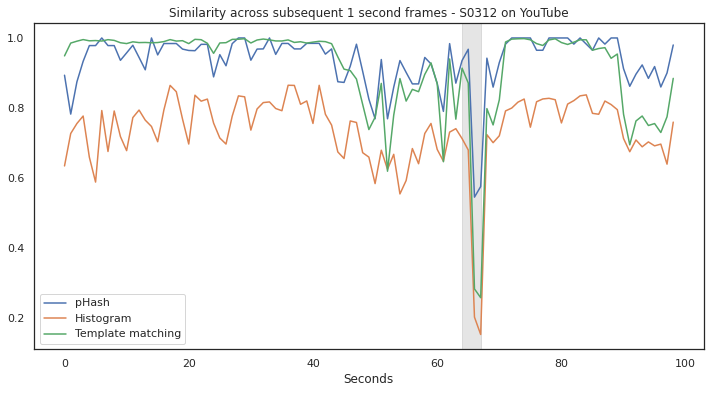

In [21]:
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

#Second when skip happens and its duration
vid_skips = [65, 2]

sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("white")

p = sns.lineplot(data=simil_df['phash_sim'], label = 'pHash')
sns.lineplot(data=simil_df['hist_sim'], label = 'Histogram')
sns.lineplot(data=simil_df['tempmatch_sim'], label = 'Template matching')
p.set_xlabel('Seconds')
p.set_ylabel('')
p.set_title('Similarity across subsequent 1 second frames - ' + dive_id + ' on YouTube')
p.add_patch(Rectangle((vid_skips[0] - 1,0), vid_skips[1] + 1 , 1.5, color = 'black', alpha = 0.1))

plt.savefig(dive_path + '/' + 'simil_' + dive_id + '_1s_100.png')

### Frames every 2 seconds

In [25]:
simil_df = sim.comp_sim_cont_frames([val for i, val in enumerate(frames[0:100]) if i%2==0],
                        comp_phash = True, comp_hist = True,
                        comp_tempmatch = True)
simil_df.head()

,FrameA_path,FrameB_path,phash_sim,hist_sim,tempmatch_sim
0,../images/S0312/YT_720p_0f.png,../images/S0312/YT_720p_60f.png,0.680851,0.565409,0.905343
1,../images/S0312/YT_720p_60f.png,../images/S0312/YT_720p_100f.png,0.822222,0.674678,0.98575
2,../images/S0312/YT_720p_100f.png,../images/S0312/YT_720p_150f.png,0.956522,0.484372,0.983063
3,../images/S0312/YT_720p_150f.png,../images/S0312/YT_720p_210f.png,0.978261,0.596485,0.986465
4,../images/S0312/YT_720p_210f.png,../images/S0312/YT_720p_270f.png,0.914894,0.64205,0.976146


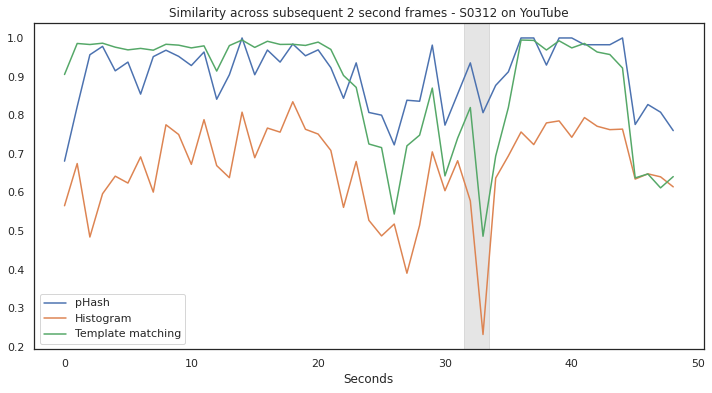

In [26]:
p = sns.lineplot(data=simil_df['phash_sim'], label = 'pHash')
sns.lineplot(data=simil_df['hist_sim'], label = 'Histogram')
sns.lineplot(data=simil_df['tempmatch_sim'], label = 'Template matching')
p.set_xlabel('Seconds')
p.set_ylabel('')
p.set_title('Similarity across subsequent 2 second frames - ' + dive_id + ' on YouTube')
p.add_patch(Rectangle((vid_skips[0]/2 - 1,0), vid_skips[1]/2 + 1 , 1.5, color = 'black', alpha = 0.1))

plt.savefig(dive_path + '/' + 'simil_' + dive_id + '_2s_100.png')

2 second between frames might not be enough to sensibly identify skips 
## Full-video analysis
We will only compute the template matching similarity score, since it seems to do fairly well in identifying the skip and it does not require much time to compute. This way we simplify the analysis and also save some computation time. 

In [28]:
simil_df = sim.comp_sim_cont_frames(frames, comp_phash = False, comp_hist = False,
                                    comp_tempmatch = True)
simil_df.head()

,FrameA_path,FrameB_path,tempmatch_sim
0,../images/S0312/YT_720p_0f.png,../images/S0312/YT_720p_30f.png,0.948823
1,../images/S0312/YT_720p_30f.png,../images/S0312/YT_720p_60f.png,0.98539
2,../images/S0312/YT_720p_60f.png,../images/S0312/YT_720p_90f.png,0.990818
3,../images/S0312/YT_720p_90f.png,../images/S0312/YT_720p_100f.png,0.995378
4,../images/S0312/YT_720p_100f.png,../images/S0312/YT_720p_120f.png,0.99187


In [32]:
simil_df['Seconds'] = ''
for row in range(simil_df.shape[0]):
    str = re.sub('../images/S0312/YT_720p_', '', simil_df['FrameA_path'][row])
    simil_df['Seconds'][row] = int(re.sub('f.png', '', str))/30

simil_df.to_pickle('{dive_id}_1s.pickle')
simil_df.head()

,FrameA_path,FrameB_path,tempmatch_sim,Seconds
0,../images/S0312/YT_720p_0f.png,../images/S0312/YT_720p_30f.png,0.948823,0.0
1,../images/S0312/YT_720p_30f.png,../images/S0312/YT_720p_60f.png,0.98539,1.0
2,../images/S0312/YT_720p_60f.png,../images/S0312/YT_720p_90f.png,0.990818,2.0
3,../images/S0312/YT_720p_90f.png,../images/S0312/YT_720p_100f.png,0.995378,3.0
4,../images/S0312/YT_720p_100f.png,../images/S0312/YT_720p_120f.png,0.99187,3.333333


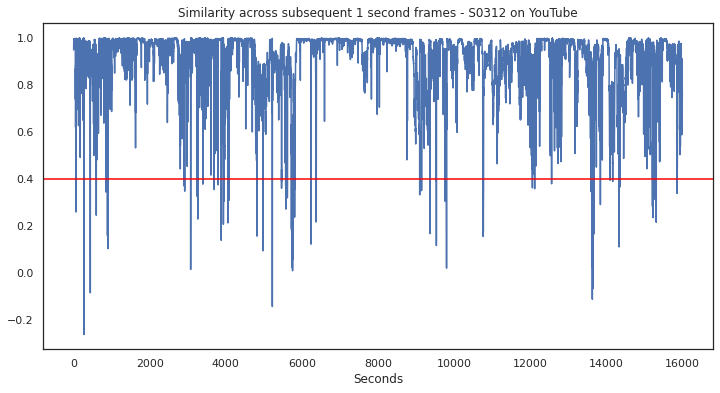

In [36]:

sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("white")

p = sns.lineplot(data=simil_df, y = 'tempmatch_sim', x = 'Seconds')
p.set_xlabel('Seconds')
p.set_ylabel('')
p.set_title('Similarity across subsequent 1 second frames - ' + dive_id + ' on YouTube')
p.axhline(0.4, color = 'red')

plt.savefig(dive_path + '/' + 'simil_' + dive_id + '_1s_full.png')

We set an arbitrary horizontal cutoff on 0.4; i.e. any moment where the similarity score is below 0.4 is suspicious of being a skip.

In [42]:
simil_df['Potential skip'] = simil_df['tempmatch_sim']<0.4
print('Potential skips if threshold is 0.4:', sum(simil_df['Potential skip']))
print('Max:', simil_df['tempmatch_sim'].max())
print('Min:', simil_df['tempmatch_sim'].min())
print('Mean:', simil_df['tempmatch_sim'].mean())
print('Std:', simil_df['tempmatch_sim'].std())
print('Percentiles:')
print(simil_df['tempmatch_sim'].quantile(q=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

Potential skips if threshold is 0.4: 190
Max: 0.9999417066574097
Min: -0.26324793696403503
Mean: 0.9109631412461026
Std: 0.12882410185978682
Percentiles:
0.01    0.375554
0.05    0.649317
0.25    0.882793
0.50    0.965386
0.75    0.990763
0.95    0.996793
0.99    0.998891
Name: tempmatch_sim, dtype: object
